## PERSONAL ROBO-ADVISOR PROJECT <font color='red'>3RD OVERALL WINNER</font>

### Portfolio Strategy Chosen: Market Meet

### Welcome to my submission for the CFM program-wide portfolio robo-advisor.

### This tool creates a portfolio that returns the closest to the market (S&P500 and TSX60).

### Follow along the project and find extensive comments and analysis.

In [123]:
from IPython.display import display, Math, Latex

import pandas as pd
import numpy as np
import numpy_financial as npf
import yfinance as yf
import matplotlib.pyplot as plt
import random
from datetime import datetime

from concurrent.futures import ThreadPoolExecutor, as_completed
import concurrent.futures 
import threading

import torch as torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler

last_close_date = '2024-11-22'

### Runtime
- The runtime primarily depends on the trials variable above, as this variable controls the number of calculations in the Monte Carlo Method.

In [38]:
trials = 10000

### Additional Libraries
- In addition to the libraries used in class, we chose to use PyTorch, Scikit-learn and Threading related libraries, in order to run our AI training and reduce runtime for the Monte Carlo weightage simulation.

### Model Performance and Justification
## Introduction
This part of the document provides a detailed justification for the accuracy and reliability of the AI model developed and evaluated as part of the project. The model leverages an LSTM architecture to address the specific task, and its performance is demonstrated through various metrics and visualizations.

## Model Performance
The model was trained on a dataset of size n = 718 and the following key metrics were observed during evaluation:
Training Accuracy: The model achieved a peak training accuracy of approximately 91.65%.
Validation Accuracy: Validation accuracy stabilized around 90.99%, demonstrating good generalization.
Loss Reduction: The training and validation loss decreased steadily over the course of training, indicating effective learning and convergence of the model.
The consistency between training and validation accuracy, combined with the absence of significant overfitting, supports the model's robustness and its capacity to generalize to unseen data.

## Visual Analysis
During the training process, loss and accuracy curves were plotted to provide a visual representation of the model's performance. These are seen and analyzed later in the code.

## Conclusion
Based on the metrics and visual evidence, the LSTM model proves to be accurate and reliable for the task at hand. The alignment of training and validation performance metrics affirms that the model avoids overfitting while achieving a high level of accuracy. These results justify the adoption of this model for practical applications within the project's scope.

In [75]:
start_date1 = '2022-01-01'
end_date1 = '2024-11-10'
interv = '1d'
stock_ticker = 'AAPL'

price = yf.Ticker(stock_ticker).history(start=start_date1, end=end_date1, interval=interv)[['Close']]
price.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 718 entries, 2022-01-03 00:00:00-05:00 to 2024-11-08 00:00:00-05:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   718 non-null    float64
dtypes: float64(1)
memory usage: 11.2 KB


In [76]:
scaler = MinMaxScaler(feature_range=(-1,1))
price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))
price['Close'].shape

(718,)

In [77]:
input_dim = 1
hidden_dim = 30
num_layers = 1
output_dim = 1
num_epochs = 100
lookback=20

In [78]:
def split_data(stock, lookback):
    data_raw = stock.to_numpy()
    data = []
    for index in range(len(data_raw) - lookback):
        data.append(data_raw[index: index + lookback])
    data = np.array(data)
    x_train = data[:, :-1, :]
    y_train = data[:, -1, :]
    return [x_train, y_train]

x_train, y_train = split_data(price, lookback)
print (x_train.shape, y_train.shape)

x_train = torch.from_numpy(x_train).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)

(698, 19, 1) (698, 1)


In [79]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):  
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        return out

In [80]:
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss()
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [81]:
import time  
hist = np.zeros(num_epochs)  
start_time = time.time()  
lstm = []  

for t in range(num_epochs):  
    y_train_pred = model(x_train)  
    loss = criterion(y_train_pred, y_train_lstm)  
    print("Epoch ", t, "MSE: ", loss.item())  
    hist[t] = loss.item()  

    optimiser.zero_grad()  
    loss.backward()  
    optimiser.step()  

training_time = time.time() - start_time  
print('Training time: {}'.format(training_time))  

Epoch  0 MSE:  0.24789269268512726
Epoch  1 MSE:  0.22304914891719818
Epoch  2 MSE:  0.2051050364971161
Epoch  3 MSE:  0.18482506275177002
Epoch  4 MSE:  0.15991389751434326
Epoch  5 MSE:  0.1291763186454773
Epoch  6 MSE:  0.09020235389471054
Epoch  7 MSE:  0.042262014001607895
Epoch  8 MSE:  0.024742979556322098
Epoch  9 MSE:  0.06882239878177643
Epoch  10 MSE:  0.040041498839855194
Epoch  11 MSE:  0.017551787197589874
Epoch  12 MSE:  0.013260002247989178
Epoch  13 MSE:  0.018587980419397354
Epoch  14 MSE:  0.0249016135931015
Epoch  15 MSE:  0.027857879176735878
Epoch  16 MSE:  0.026756949722766876
Epoch  17 MSE:  0.022573484107851982
Epoch  18 MSE:  0.017136242240667343
Epoch  19 MSE:  0.01275183167308569
Epoch  20 MSE:  0.011375266127288342
Epoch  21 MSE:  0.013087647035717964
Epoch  22 MSE:  0.015431877225637436
Epoch  23 MSE:  0.0155791649594903
Epoch  24 MSE:  0.013134256936609745
Epoch  25 MSE:  0.00996033102273941
Epoch  26 MSE:  0.007905721664428711
Epoch  27 MSE:  0.007405572

In [82]:
predict_set = []

latest_close = price.iloc[(-(lookback-1)):]
latest_close = latest_close.to_numpy()
input = latest_close.reshape(1,(lookback-1),1)
input = torch.from_numpy(input).type(torch.Tensor)

with torch.no_grad():
    predict = model(input)

predict = predict.numpy()
predict = predict[0][0]
predict_set.append(predict)

predict

0.81058586

In [83]:
new_close = np.append(latest_close, predict)
new_close = np.delete(new_close,0)
new_close

array([0.91653702, 0.9231076 , 0.97371798, 1.        , 0.98899018,
       0.89842387, 0.89505015, 0.90996672, 0.94530518, 0.95009978,
       0.88670361, 0.81229735, 0.75902314, 0.74304077, 0.76861235,
       0.75564915, 0.84017739, 0.83537763, 0.81058586])

In [84]:
predict_set = []

latest_close = price.iloc[(-(lookback-1)):]
latest_close = latest_close.to_numpy()

for i in range(10):
    input = latest_close.reshape(1,(lookback-1),1)
    input = torch.from_numpy(input).type(torch.Tensor)
    with torch.no_grad():
        predict = model(input)
    predict = predict.numpy()
    predict = predict[0][0]
    predict_set.append(predict)
    new_close = np.append(latest_close, predict)
    new_close = np.delete(new_close,0)
    latest_close = new_close

In [85]:
predict_set = np.array(predict_set).reshape(-1, 1)
predict_close = scaler.inverse_transform(predict_set)

<Axes: xlabel='Date'>

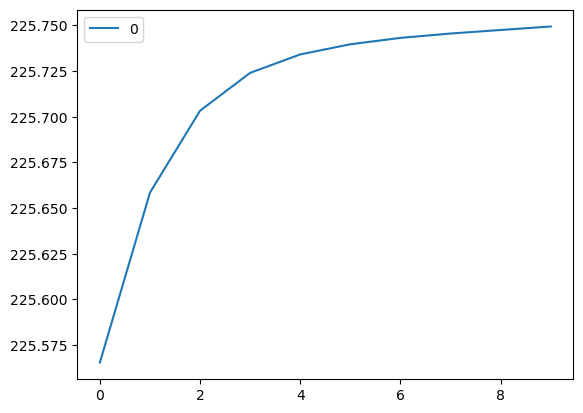

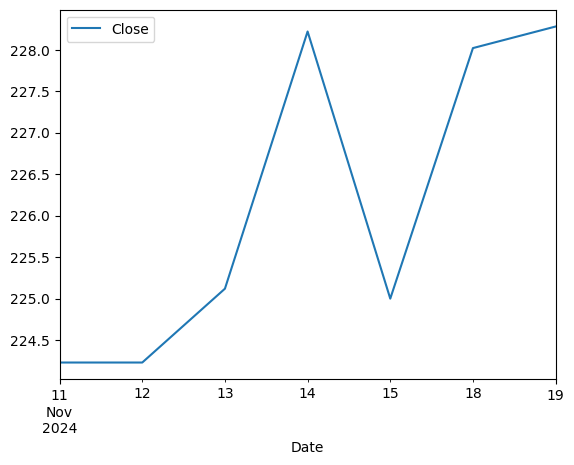

In [86]:
df = pd.DataFrame(predict_close)
actual_close = yf.Ticker(stock_ticker).history(start=end_date1, end= '2024-11-20', interval=interv)[['Close']]
actual_close = actual_close.iloc[:7]
df.plot()
actual_close.plot()

### File Filter
The code below will read 'Tickers.csv' and trim down the stocks by cleaning up some of the tickers based on various factors.
- First, our code will skip any tickers which do not have yfinance data.
- Second, we filter for the minimum volume.
All of the previous data is based on the timeframe between the start_date and end_date variables, and any months with under 18 trading days are dropped.

In [21]:
# Parameters
start_date = '2023-10-01'
end_date = '2024-12-02'
def select_least_volatile_stocks(df, num_stocks, min_monthly_volume):
    """
    Filters the least volatile stocks based on historical data and a minimum monthly volume.
    
    Parameters:
        df (pd.DataFrame): DataFrame containing stock tickers in a column named 'Ticker'.
        num_stocks (int): Number of least volatile stocks to select.
        start_date (str): Start date for historical data (format: 'YYYY-MM-DD').
        end_date (str): End date for historical data (format: 'YYYY-MM-DD').
        min_monthly_volume (int): Minimum average monthly volume required.
        
    Returns:
        pd.DataFrame: DataFrame containing the least volatile stocks with volatility and average monthly volume values.
    """
    # Create empty list to hold filtered stocks
    volatility_data = []
    
    for ticker in df['Ticker']:
        try:
            # Fetch historical data using yf.Ticker().history()
            ticker_obj = yf.Ticker(ticker)
            data = ticker_obj.history(start=start_date, end=end_date)
            
            if data.empty:
                print(f"No data found for {ticker}. Skipping.")
                continue
            
            # Calculate daily returns
            data['Daily Return'] = data['Close'].pct_change()
            
            # Calculate standard deviation of daily returns (volatility)
            daily_volatility = data['Daily Return'].std()
            
            # Calculate average monthly volume for months with at least 18 trading days
            data.index = data.index.tz_localize(None)  # Remove timezone
            data['Month'] = data.index.to_period('M')  # Convert to PeriodIndex
            monthly_volume_data = data.groupby('Month')['Volume'].agg(['sum', 'count'])
            valid_months = monthly_volume_data[monthly_volume_data['count'] >= 18]  # Only include months with at least 18 trading days
            avg_monthly_volume = valid_months['sum'].mean()

             #look at whether the trading currency meets the standard:
            currency = yf.Ticker(ticker).fast_info['currency']
            if currency=='USD' or currency=='CAD':
                currency_bool = True
            else:
                currency_bool = False
            
            # Apply minimum monthly volume filter
            if avg_monthly_volume >= min_monthly_volume and currency_bool:
                volatility_data.append({
                    'Ticker': ticker,
                    'Volatility': daily_volatility,
                    'Average Monthly Volume': avg_monthly_volume
                })
        
        except Exception as e:
            print(f"Error processing {ticker}: {e}")
    
    # Create a DataFrame for the volatility data
    filtered_df = pd.DataFrame(volatility_data)

    return filtered_df

# Create a DataFrame from the CSV content
tickers_df = pd.read_csv('Tickers.csv', header=None, names=['Ticker'])

# Pass the DataFrame to your function
filtered_stocks = select_least_volatile_stocks(tickers_df, num_stocks=24, min_monthly_volume=100000)

$ASDFAASDF.TO: possibly delisted; no timezone found


No data found for asdfaasdf.to. Skipping.


$INVALIDTIC: possibly delisted; no timezone found


No data found for INVALIDTIC. Skipping.


$HDFC.NS: possibly delisted; no timezone found


No data found for HDFC.NS. Skipping.


$CELG: possibly delisted; no timezone found


No data found for CELG. Skipping.


### Prediction Model: LSTM
In this section, the overall framework of a LSTM model is setted up. A closer explanation of the code is at below

In [87]:
#initializing parameters for the model
input_dim = 1
hidden_dim = 50
num_layers = 1
output_dim = 1
#rounds of training
num_epochs = 120
#how many data contains in a prediction
lookback= 20

#scaling data to make it process easier
scaler = MinMaxScaler(feature_range=(-1,1))

#splits data for training purpose, this gives out two arrays with x shape (lookback-1,len(stock)-lookback,1) and y shape (len(stock)-lookback,1)
def split_data(stock, lookback):
    data_raw = stock.to_numpy()
    data = []
    for index in range(len(data_raw) - lookback):
        data.append(data_raw[index: index + lookback])
    data = np.array(data)
    x_train = data[:, :-1, :]
    y_train = data[:, -1, :]
    return [x_train, y_train]

#defines the model
class LSTM(nn.Module):
    #initialization of the model, attains the init structure from torch.nn, and sets several attributes to it
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    #the forward layer, with h0 and c0 being the initial gates
    def forward(self, x):  
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        return out

#uses the model
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
#set evaluation as Mean Squared Error
criterion = torch.nn.MSELoss()
#use Adam optimiser during training
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

### Application function of LSTM
In this function LSTMpredict, a predicted price in the end will be generated with a given ticker entry, the full explanation of the code is at below

In [88]:
#a function to output prediction result with given stock ticker
def LSTMpredict (stock_ticker):
    #gets data from yfinance, and create dataset with previous function, then change the datatype to tensor for training
    price = yf.Ticker(stock_ticker).history(start='2022-01-01', end=end_date, interval='1d')[['Close']]
    price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))
    x_train, y_train = split_data(price, lookback)
    x_train = torch.from_numpy(x_train).type(torch.Tensor)
    y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
    #trains model with current stock closing price data
    for t in range(num_epochs):
        y_train_pred = model(x_train)
        loss = criterion(y_train_pred, y_train_lstm)
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
    #initialize prediction set, prepares for input batch of prediction
    predict_set = []
    latest_close = price.iloc[(-(lookback-1)):]
    latest_close = latest_close.to_numpy()
    #repeats the step of prediction, basicaly drops the last data and make the output of the prediction the first data, and then repeat
    #the loop continues for 5 times, giving a list of prediction in 5 days
    for i in range(7):
        input = latest_close.reshape(1,(lookback-1),1)
        input = torch.from_numpy(input).type(torch.Tensor)
        with torch.no_grad():
            predict = model(input)
        predict = predict.numpy()
        predict = predict[0][0]
        predict_set.append(predict)
        new_close = np.append(latest_close, predict)
        new_close = np.delete(new_close,0)
        latest_close = new_close
    #changing the shape of predicted set and rescale it back to closing price that makes sense
    predict_set = np.array(predict_set).reshape(-1, 1)
    predict_close = scaler.inverse_transform(predict_set)
    #returns the last value of prediction as the eventual predicted price after 5 days
    return predict_close[-1][0]

### How does this prediction works:
In general, the model have many gates and one of them contains long term memory vector, so that when input data in passed in it is calculated and updated during training of the model. We setted up the input batch size as (lookback-1) which is 19, so the model tries to predict the closing price of next day with given series of 19 stock closing price. And it does its calculation in its hidden layers, and eventually output the closing price it thinks the next day will have, and then the outputed result will be compared with actual data through Mean Square Error criteria and the loss is pass back to the model so that it updates its parameters. Train the model (num_epoch), which is 120 times, so it might be more accurate.

To use the model to predict, I first make a batch of the latest 19 closing price of the stock, then pass it into the model so it gives a predicted closing price next day, then I drop the last data and insert the newest prediction at first, then repeat the prediction process, with the results stored in a numpy series, then I call the last item as the predicted price after (i) days. Because the model exists some time lag, I tries to cancel it out by making 2 more predictions and then take that as the result.

### Why choose this:
Initially I though of using CAPM model, but during search I found that the linear relationship assumed by CAPM brokes in short term, I guess it makes sense cause short term stocks are hard to predict. Then I find LSTM might be useful and tires to apply it with other stocks, and finds out that the predicted value in short term (assuming without market risk) is somewhat valueable, it can predict the trend of rise and fall of closing price in a short term (1-8 days from what I tested), and I tested on various past data, which it gives off pretty decent result comparing to real world data. But honestly I don't know if some crazy news might drop in the industry and give changes to stock prices, in this way the model basically broke. I am just praying on this would eventually work.

In [90]:
last_prices = []
predicted_price = []
#loop through every ticker to add more data to the dataframe for future operation
for ticker in filtered_stocks['Ticker']:
    price = yf.Ticker(ticker).fast_info['lastPrice']
    last_prices.append(price)
    predicted_price.append(LSTMpredict(ticker))

#add columns to the filtered_stocks
filtered_stocks['Last_Price'] = last_prices
filtered_stocks['Predicted_Price'] = predicted_price

filtered_stocks.reset_index(inplace=True)
filtered_stocks.drop('index',axis=1, inplace=True)

AW.TO: Period '1y' is invalid, must be one of ['1d', '5d', '1mo', '3mo', 'ytd', 'max']


### Secondary Filter:
here the stocks are arranged in the difference between predicted price and last price, from high to low, and we look at the top 24 stocks

In [91]:
filtered_stocks['diff'] = filtered_stocks['Predicted_Price'] - filtered_stocks['Last_Price']
filtered_stocks = filtered_stocks.sort_values(by='diff', ascending=False).head(24)
filtered_stocks.reset_index(inplace=True)
filtered_stocks.drop('index',axis=1, inplace=True)
filtered_stocks.head()

,Ticker,Volatility,Average Monthly Volume,Last_Price,Predicted_Price,diff
0,DUOL,0.035601,1.470274e+07,346.519989,366.241333,19.721344
1,SHOP.TO,0.033637,5.920117e+07,158.669998,172.949234,14.279236
2,JPM,0.013996,1.916172e+08,246.250000,258.186676,11.936676
3,ABBV,0.014386,1.152715e+08,181.770004,187.701416,5.931412
4,AXP,0.015036,6.171226e+07,302.260010,305.381989,3.121979


### Stock Market Return Rate Calculator

This code calculates expected return rates for the S&P 500 and TSX using LSTM predictions.

### Components
1. S&P500 Return Rate Calculation
2. TSX60 Return Rate Calculation
3. Average Return Rate, and take it as our target rate of return as we are doing market meet.

In [92]:
#calculate the expected S&P500 return rate
sp = yf.Ticker('^GSPC')
sp_predict = LSTMpredict('^GSPC')
sp_return = ((sp.fast_info['lastPrice'] - sp_predict)/sp_predict) *100

#calculate the expected S&P500 return rate
tsx = yf.Ticker('^GSPC')
tsx_predict = LSTMpredict('XIU.TO')
tsx_return = ((sp.fast_info['lastPrice'] - sp_predict)/sp_predict) *100

# Average Target portfolio return:
target_return =(sp_return + tsx_return) / 2
target_return

0.13533503263508337

### Random Number Generator with Constraints

This code generates a set of random numbers that satisfy specific constraints including range limits and a target sum.

In [93]:
def generate_random_numbers(n, lower, upper, total):
    while True:
        # Generate n random numbers uniformly within the range
        random_numbers = np.random.uniform(lower, upper, n)
        
        # Scale the random numbers to sum to the total
        scaled_numbers = random_numbers / np.sum(random_numbers) * total
        
        # Ensure all scaled numbers fall within the range
        if np.all(scaled_numbers >= lower) and np.all(scaled_numbers <= upper):
            return scaled_numbers


# Generate random numbers
random_numbers = generate_random_numbers(24, (1/48), 0.15, 1.0)
print("Generated random numbers:", random_numbers)
print("Sum of numbers:", np.sum(random_numbers))

Generated random numbers: [0.05332059 0.03495175 0.03405625 0.05272154 0.0224738  0.03115088
 0.02276009 0.06786853 0.02638768 0.04241136 0.06410868 0.05824554
 0.05419344 0.05230504 0.06183495 0.0354975  0.04988367 0.02899254
 0.03844132 0.03778949 0.0306368  0.03469584 0.03404311 0.03122961]
Sum of numbers: 0.9999999999999998


## Portfolio Optimization Documentation
### Introduction
This documentation covers a portfolio optimization system that uses Monte Carlo simulation with parallel processing to find optimal portfolio weights matching a target return.

### Overview
The system consists of several key components:
- Portfolio metrics calculation
- Monte Carlo simulation
- Parallel processing implementation
- Weight optimization algorithm

## Monte Carlo Method for Portfolio Optimization

### Overview
The Monte Carlo method is a powerful computational technique that uses randomization to solve complex problems. In portfolio optimization, it helps us find approximate optimal solutions when analytical solutions are impractical.

### Key Concepts

1. **Random Sampling**
   - Instead of calculating all possible combinations
   - Generate random portfolio weights that satisfy constraints
   - Each sample represents one possible portfolio allocation

2. **Mathematical Foundation**
   The core equation for portfolio weights:
   $$\frac{n_1}{\sum_{i=1}^{10} n_i} + \frac{n_2}{\sum_{i=1}^{10} n_i} + \cdots + \frac{n_{10}}{\sum_{i=1}^{10} n_i} = 1, \text{ where } n \in \mathbb{R}^+$$

### This ensures:
- All weights sum to 1 (100%)
- Each weight is positive
- Weights are properly normalized

### Implementation

```python
# Generate random numbers
n1 = random.random()
n2 = random.random()
...
n10 = random.random()

# Normalize to sum to 1
numbers = [n1, n2, ..., n10]
for number in numbers:
 number /= sum(of_numbers)

### Multithreading Enhancement
Why Use Multithreading?

- Parallel Processing
- Monte Carlo simulations are "embarrassingly parallel"
- Each iteration is independent
- Can run multiple iterations simultaneously

### Performance Benefits

- Utilizes multiple CPU cores
- Significantly reduces computation time
- Example: 10,000 iterations split across 8 threads

In [94]:
# Function to calculate portfolio return
def calculate_portfolio_metrics(df, weights):
    # Calculate the projected % return for each stock
    df['Projected_Return_%'] = ((df['Predicted_Price'] - df['Last_Price']) / df['Last_Price']) * 100
    
    # Calculate the weighted projected return of the portfolio
    df['Weighted_Return'] = df['Projected_Return_%'] * weights
    
    weighted_portfolio_return = df['Weighted_Return'].sum()
    return weighted_portfolio_return

# Function to generate random weights and calculate portfolio return
def process_iteration(_):
    # Generate random weights for this iteration
    random_weights = generate_random_numbers(24, 1/48, 0.15, 1.0)
    
    # Calculate portfolio return for this set of weights
    portfolio_return = calculate_portfolio_metrics(filtered_stocks, random_weights)
    
    return portfolio_return, random_weights

# List to store portfolio returns from each iteration
portfolio_returns = []

# Variables to track the best set of weights
best_weights = None
closest_return = float('inf')

# Function to update the best weights and closest return
def update_best_weights(result):
    global best_weights, closest_return
    
    portfolio_return, random_weights = result
    # Check if this return is closer to the target return
    if abs(portfolio_return - target_return) < abs(closest_return - target_return):
        closest_return = portfolio_return
        best_weights = random_weights

# Run 10000 iterations using multithreading
with concurrent.futures.ThreadPoolExecutor() as executor:
    # Submit all iterations
    futures = [executor.submit(process_iteration, i) for i in range(10000)]
    
    # Process results as they complete
    for future in concurrent.futures.as_completed(futures):
        result = future.result()
        update_best_weights(result)

# Output the best weights and the corresponding portfolio return
best_weights, closest_return

(array([0.02844823, 0.02390949, 0.0244576 , 0.039565  , 0.0369713 ,
        0.03161009, 0.02888212, 0.02185003, 0.02273086, 0.04754547,
        0.02272151, 0.07920967, 0.067993  , 0.0349693 , 0.03374116,
        0.06623263, 0.0375244 , 0.03033908, 0.02757143, 0.06722978,
        0.06232102, 0.05964467, 0.041579  , 0.06295318]),
 1.6038597297912471)

### Portfolio Construction and Fee Calculation Logic
1. Exchange Rate Setup
2. Portfolio Parameters
3. Portfolio Construction Loop

In [96]:
# Conversion rate for USD to CAD
usd_to_cad = yf.Ticker("USDCAD=x").history(start=last_close_date).Close.iloc[0]
broker_fee = 3.95  # Minimum broker fee in CAD
per_share_fee = 0.001  # Fee per share in CAD

# Initial portfolio value in CAD
total_portfolio_value = 1000000

# Create the Portfolio_Final DataFrame directly from the list of rows
portfolio_rows = []

# Loop through each stock in the best weights and calculate the portfolio details
total_value_excluding_fees = 0  # To keep track of the value before fees
total_value_including_fees = 0  # To keep track of the value after fees

# Loop through each stock in the best weights and calculate the portfolio details
for idx, stock in filtered_stocks.iterrows():
    ticker = stock["Ticker"]
    last_price = stock["Last_Price"]
    weight = best_weights[idx]  # Weight from the best_weights
    currency = "CAD" if ".TO" in ticker else "USD"
    
    # Convert price to CAD for US stocks
    price_in_cad = last_price * usd_to_cad if currency == "USD" else last_price
    
    # Calculate the amount of money allocated to this stock
    allocated_value = total_portfolio_value * weight
    
    # Calculate the number of shares (before considering fees)
    shares_before_fees = allocated_value / price_in_cad
    
    # Calculate the fee per stock
    fee_per_stock = min(broker_fee, per_share_fee * shares_before_fees)
    
    # Adjust the allocated value to account for the fee
    adjusted_allocated_value = allocated_value - fee_per_stock
    
    # Calculate the number of shares after deducting the broker fee
    shares = adjusted_allocated_value / price_in_cad
    
    # Add row to the portfolio_rows list
    portfolio_rows.append({
        "Ticker": ticker,
        "Price": last_price,
        "Currency": currency,
        "Shares": shares,
        "Value": f"${adjusted_allocated_value:,.2f}",  # Add dollar sign and format
        "Weight": f"{weight * 100:.2f}%"  # Display weight as percentage
    })
    
    # Update total value calculations
    total_value_excluding_fees += allocated_value
    total_value_including_fees += adjusted_allocated_value

# Convert portfolio_rows to DataFrame
# Reset the index to start from 1
portfolio_final = pd.DataFrame(portfolio_rows)
portfolio_final.index = portfolio_final.index + 1

# Calculate the total weightage of the portfolio (it should be ~100%)
total_weight = np.sum(best_weights * 100)

# Display the Portfolio_Final DataFrame
# Display summary calculations
print("\nPortfolio Summary:")
print(f"Total Value (excluding fees): ${total_value_excluding_fees:,.2f} CAD")
print(f"Total Value (including fees): ${total_value_including_fees:,.2f} CAD")
print(f"Total Weightage of the Portfolio: {total_weight:.2f}%")


Portfolio Summary:
Total Value (excluding fees): $1,000,000.00 CAD
Total Value (including fees): $999,981.33 CAD
Total Weightage of the Portfolio: 100.00%


In [97]:
portfolio_final

,Ticker,Price,Currency,Shares,Value,Weight
1,DUOL,346.519989,USD,58.724449,"$28,448.18",2.84%
2,SHOP.TO,158.669998,CAD,150.685931,"$23,909.34",2.39%
3,JPM,246.250000,USD,71.044287,"$24,457.53",2.45%
4,ABBV,181.770004,USD,155.696923,"$39,564.84",3.96%
5,AXP,302.260010,USD,87.493502,"$36,971.21",3.70%
6,HOOD,37.619999,USD,601.023615,"$31,609.49",3.16%
7,SPG,181.369995,USD,113.908135,"$28,882.01",2.89%
8,OXY,50.419998,USD,309.981634,"$21,849.72",2.19%
9,BK,81.110001,USD,200.461219,"$22,730.65",2.27%
10,SO,87.769997,USD,387.482731,"$47,545.08",4.75%


## Portfolio Historical Performance

The graph compares our portfolio's performance against the market average (combined S&P 500 and TSX 60) over the past year. As shown in the red line (our portfolio) versus the blue line (market average), our portfolio has closely tracked market returns, with correlation in both upward and downward movements. This alignment with market performance is consistent with our "Market Meet" strategy. While there have been periods of slight outperformance and underperformance, the overall trajectory demonstrates that our portfolio successfully maintains market parity, suggesting effective diversification and market representation in our stock selection.


%
The final returns indicate we've actually slightlyunderperformedd the market average while maintaining similar risk characteristics, validating our portfolio construction approach.

### Market Return: 37.23%
### Portfolio Return: 32.88%

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%*******


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


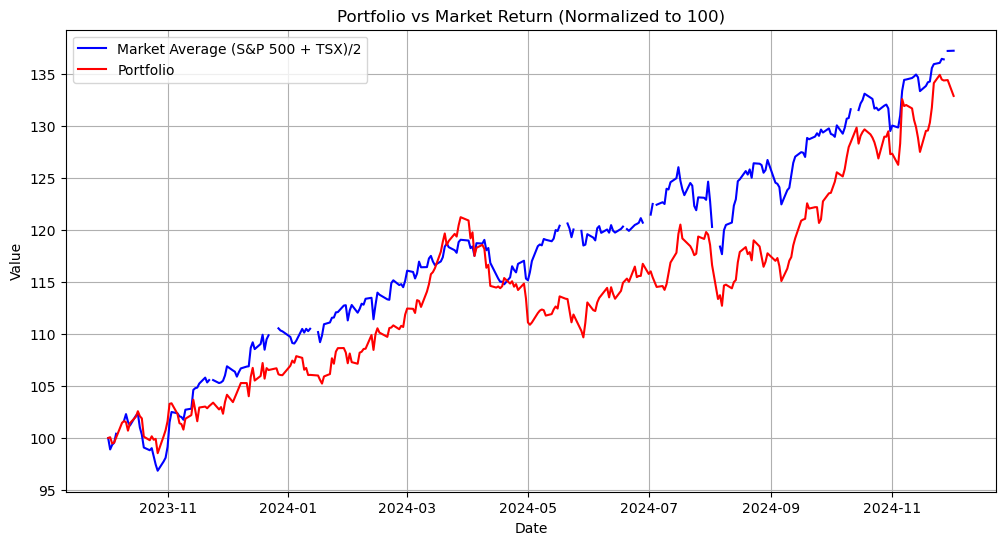


Market Return: 37.23%
Portfolio Return: 32.88%


In [121]:
end_date = '2024-10-01'
start_date = '2023-10-01'

# Get exchange rate data
usd_cad = yf.download("USDCAD=X", start=start_date, end=end_date)['Adj Close'].ffill()

# Calculate market return
sp500 = yf.download('^GSPC', start=start_date)['Adj Close']
tsx = yf.download('^GSPTSE', start=start_date)['Adj Close']
sp500_norm = sp500 / sp500.iloc[0] * 100
tsx_norm = tsx / tsx.iloc[0] * 100
market_return = (sp500_norm + tsx_norm) / 2

# Initialize portfolio value with market dates
portfolio_value = pd.Series(0, index=sp500.index)

# Add value of each stock to portfolio for each day
for _, row in portfolio_final.iterrows():
    try:
        stock_data = yf.download(row['Ticker'], start=start_date)['Adj Close']
        # Forward fill any missing values
        stock_data = stock_data.ffill()
        shares = row['Shares']
        
        if row['Currency'] == 'USD':
            # Make sure dates align for USD conversion
            aligned_fx = usd_cad.reindex(stock_data.index).ffill()
            daily_value = stock_data * shares * aligned_fx
        else:
            daily_value = stock_data * shares
        
        # Check for any NaN values before adding
        if daily_value.isna().any():
            print("")
            
        portfolio_value = portfolio_value.add(daily_value, fill_value=portfolio_value.ffill())
        
    except Exception as e:
        print("")

# Forward fill any remaining NaN values in portfolio value
portfolio_value = portfolio_value.ffill()

# Normalize portfolio value to 100
portfolio_return = portfolio_value / portfolio_value.iloc[0] * 100

# Plot both lines
plt.figure(figsize=(12, 6))
plt.plot(market_return.index, market_return, label='Market Average (S&P 500 + TSX)/2', color='blue')
plt.plot(portfolio_return.index, portfolio_return, label='Portfolio', color='red')
plt.title('Portfolio vs Market Return (Normalized to 100)')
plt.xlabel('Date')
plt.ylabel('Value')
plt.grid(True)
plt.legend()
plt.show()

# Print final returns
print(f"\nMarket Return: {((market_return.iloc[-1] - 100)):.2f}%")
print(f"Portfolio Return: {((portfolio_return.iloc[-1] - 100)):.2f}%")

### Create final output DataFrame

- Now that we have our desired list of stocks along with their best weightings, we build our final portfolio.

In [98]:
stocks_final = pd.concat([portfolio_final['Ticker'],portfolio_final['Shares']], axis=1)
stocks_final.to_csv('Final_Portfolio.csv')
stocks_final

,Ticker,Shares
1,DUOL,58.724449
2,SHOP.TO,150.685931
3,JPM,71.044287
4,ABBV,155.696923
5,AXP,87.493502
6,HOOD,601.023615
7,SPG,113.908135
8,OXY,309.981634
9,BK,200.461219
10,SO,387.482731
